In [1]:
# import functions
import sys,os
import glob
try: 
    if(cwd is not None):
        from functions.utils_binary import *
except:
    %cd ..
    cwd = os.getcwd()
    sys.path.insert(0,cwd)
    from functions.utils_binary import *

c:\Users\User\Documents\5-fold_3d7_proba


In [2]:
# prepare data for training
defineXY(testSize=0.2, trainSize=0.8, randomState=4) # only needed to be run once

## Boosting methods (XGBoost, Ada and LightGBM)

In [ ]:
# setting search space

xgb_search = {
'learning_rate': Real(0.01, 1.0, 'uniform'),
'max_depth': Integer(2, 12),
'subsample': Real(0.1, 1.0, 'uniform'),
'colsample_bytree': Real(0.1, 1.0, 'uniform'),
'reg_alpha': Real(1e-9, 100., 'uniform'),
'n_estimators': Integer(50, 5000)
}

ada_search = {
    'learning_rate': Real(0.005, 0.9, prior="log-uniform"),
    'n_estimators': Integer(1, 1000),
}

lgbm_search = {
    'reg_sqrt': Categorical([True, False]),
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(1, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

In [ ]:
# scorer
f1_scorer = make_scorer(f1_score, pos_label=1)

# Setting the validation strategy
inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [ ]:
# initiate models
init_models = [xgb.XGBClassifier(), LGBMClassifier(), AdaBoostClassifier()]

# search spaces
search_spaces = [xgb_search, lgbm_search, ada_search]

In [ ]:
# define fp generated
fp_generated = ['ecfp_fp_2_2048', 'fcfp_fp_2_2048', 'maccs_fp']

for fp in fp_generated:

    # run through x train
    for file in os.listdir('./data/curated_data/x/binary/x_train/'):

        # run through y train
        for file_ in os.listdir('./data/curated_data/y/binary/y_train/'):

            # check if file is json file
            if file.endswith('json'):

                #check if files share the same fp, if so, continue
                if file.find(fp) != -1 and  file_.find(fp) != -1:
                    
                    # load x_train
                    with open(f'./data/curated_data/x/binary/x_train/{file}', 'r') as x_train:
                        x_train = json.load(x_train)
                        x_train= np.asarray(x_train)


                    # load y_train
                    with open(f'./data/curated_data/y/binary/y_train/{file_}', 'r') as y_train:
                        y_train = json.load(y_train)
                        y_train= np.asarray(y_train)

                    # training
                    bayessearch(
                        models = init_models, 
                        search_spaces = search_spaces, 
                        scorer = f1_scorer,
                        inner_cv = inner_skf,
                        outer_cv = outer_skf,
                        x = x_train,
                        y = y_train,
                        fp = fp
                    )

In [ ]:
%%capture
validatemodels() #only for boosting methods

# Non boosting methods

In [3]:
"""
Make sure when introducing a new classifier to create a folder with the model name at the following directories:
./data/models/binary/metrics/BACC/{MODEL_NAME}
./data/models/binary/metrics/AUC/{MODEL_NAME}
"""


# define search space
rf_search = {
    'max_features': ['sqrt'],
    'n_estimators': [100, 1000],
    'max_depth': [2, 100],
    'min_samples_leaf': [1,20], 
    'min_samples_split': [2, 20]
    }

svc_search = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

knn_search = {
    'n_neighbors' : [3, 5, 11, 19],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

# define variables
fp = 'fcfp_fp_2_2048'
model = RandomForestClassifier # classifier 
#model = SVC
#model = KNeighborsClassifier
model_name = 'rf' 


# load x_train
with open(f'./data/curated_data/x/binary/x_train/x_train_{fp}.json', 'r') as x_train:
    x_train = json.load(x_train)
    x_train= np.asarray(x_train)


# load y_train
with open(f'./data/curated_data/y/binary/y_train/y_train_{fp}.json', 'r') as y_train:
    y_train = json.load(y_train)
    y_train= np.asarray(y_train)

# scorer
f1_scorer = make_scorer(f1_score, pos_label=1)

# Setting the validation strategy
inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
outer_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# callback funtions
overdone_control = DeltaYStopper(delta=0.0001) # early stop
time_limit_control = DeadlineStopper(total_time=60*60*4) #7h time limit

# initialize model
model_ini = model(random_state=0) # classifier 

# invoke bayes search
opt = BayesSearchCV(
    estimator=model_ini, 
    search_spaces=rf_search,
    scoring=f1_scorer,
    cv=inner_skf,
    n_points=1,
    n_jobs=-1,
    return_train_score=False,
    refit=False,
    optimizer_kwargs={'base_estimator': 'GP'},
    random_state=0
)

# search for best params
best_params = report_perf(opt, x_train, y_train, callbacks=[overdone_control, time_limit_control])

# Transferring best parameters to basic classifier
basic_clas = model(**best_params)

# cross validate with best params

# cross validate to get confusion matrix
cv_results = cross_validate(basic_clas, x_train, y_train, cv=outer_skf, scoring=confusion_matrix_scorer)
# cross validate to get auc
cv_auc = cross_validate(basic_clas, x_train, y_train, cv=outer_skf, scoring='roc_auc')


cv_proba_results = cross_validate(basic_clas, x_train, y_train, cv=outer_skf, scoring=confusion_matrix_scorer_proba)
cv_proba_results = pd.DataFrame(cv_proba_results)
cv_proba_results.to_csv(f'./data/models/binary/metrics/{model_name}_classifier_5cv_{fp}_PROBA.csv', index = False)

# save cross validation auc metrics
cv_auc = pd.DataFrame(cv_auc)
cv_auc.to_csv(f'./data/models/binary/metrics/AUC/{model_name}/{model_name}_classifier_auc_{fp}.csv', index = False)

# save cross validation confusion matrix
cv_results = pd.DataFrame(cv_results)
cv_results.to_csv(f'./data/models/binary/metrics/{model_name}_classifier_5cv_{fp}.csv', index = False)
cv_results.to_csv(f'./data/models/binary/metrics/BACC/{model_name}/{model_name}_classifier_5cv_{fp}.csv', index = False)

# fit model with entire dataset
model = basic_clas.fit(x_train, y_train)

# save model
dump(model, f'./data/models/binary/{model_name}_classifier_{fp}.joblib')

model took 8940.90 seconds,  candidates checked: 50, best CV score: 0.737 ± 0.004
Best parameters:
OrderedDict([('max_depth', 93), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 5), ('n_estimators', 376)])



['./data/models/binary/rf_classifier_fcfp_fp_2_2048.joblib']

In [4]:
cv_proba_results

,fit_time,score_time,test_tn,test_fp,test_fn,test_tp
0,78.307747,0.739023,2823,469,662,1741
1,78.897171,0.740027,2828,463,689,1714
2,79.362920,0.742017,2876,415,718,1685
3,79.238322,0.745010,2842,450,685,1717
4,78.941078,0.735008,2814,478,665,1737


In [5]:
# 5 FOLD CROSS VALIDATION PLOT WITH STD 

model_metrics = pd.read_csv(f'./data/models/binary/metrics/rf_classifier_5cv_fcfp_fp_2_2048_PROBA.csv')
metrics_inner = metrics_internal_binary(model_metrics)


mean_metrics = [np.mean(metrics_inner[column]) for column in metrics_inner.columns]
std_metrics = [np.std(metrics_inner[column]) for column in metrics_inner.columns]
labels = ['Se', 'Sp', 'Precision', 'BACC', 'MCC', 'F1']

x_pos = np.arange(len(labels))
fig, ax = plt.subplots()
barplot = ax.bar(x_pos, mean_metrics,
    yerr=std_metrics,
    align='center',
    alpha=0.5,
    ecolor='black',
    capsize=10, color = 'gray')
ax.set_ylabel('Value')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.yaxis.grid(False)

ax.bar_label(barplot, labels=['±%.2f' % e for e in std_metrics], padding=3, color='black', fontsize=9)

# Save the figure and show
plt.tight_layout()
plt.savefig(f'./data/figs/rf_classifier_5cv_fcfp_fp_2_1024_5cv.png', dpi=300)
plt.clf()


<Figure size 640x480 with 0 Axes>

In [ ]:
# PLOT AUC COMPARISON PLOT PER FINGERPRINT 

# make sure to enter the correct directory where auc metrics are saved
model_0 = pd.read_csv(f'./data/models/binary/metrics/AUC/rf/rf_classifier_auc_ecfp_fp_2_1024.csv')
model_1 = pd.read_csv(f'./data/models/binary/metrics/AUC/lgbm/lgbm_classifier_auc_ecfp_fp_2_1024.csv')
model_2 = pd.read_csv(f'./data/models/binary/metrics/AUC/xgb/xgb_classifier_auc_ecfp_fp_2_1024.csv')


# change the names of the algorithm accordingly (if needed you can increase the number of models compared)
dictHolder = pd.DataFrame({'x_values':[], 'LGBM': [], 'ADABoost': [], 'XGBoost':[]})

# make sure to add one more dictHolder if more than 3 algorithms are added, or to remove one if needed
dictHolder['RF'] = [i for i in model_0['test_score']]
dictHolder['LGBM'] = [i for i in model_1['test_score']]
dictHolder['XGBoost'] = [i for i in model_2['test_score']]
dictHolder['x_values'] = [f'fold_{i}' for i in range(5)]

# multiple line plots, add one for each model and change algorithm name accordingly
plt.plot( 'x_values', 'LGBM', data=dictHolder, marker='^', markerfacecolor='white', markersize=8, color='blue', linewidth=2, 
linestyle='dashed', label = f"LGBM mean {round(st.mean(dictHolder['LGBM']), 2)}")

plt.plot( 'x_values', 'XGBoost', data=dictHolder, marker='v', markerfacecolor='white', markersize=8, color='red', linewidth=2, 
linestyle='dashed', label = f"XGBoost mean {round(st.mean(dictHolder['XGBoost']), 2)}")

plt.plot( 'x_values', 'RF', data=dictHolder, marker='x', markerfacecolor='white', markersize=8, color='black', linewidth=2, 
linestyle='dashed', label = f"RF mean {round(st.mean(dictHolder['RF']), 2)}")


# choose a title
plt.title(f'5-fold cross validation ECFP4 1024')

# choose label for y
plt.ylabel('AUC')

# show legend
plt.legend()

# save, remmeber to add the correct fingerprint in the image name before saving
#plt.savefig(f'./data/figs/auc_compared_nonboost_ecfp_fp_2_1024.png', dpi=300)
#plt.clf()

In [9]:
# PLOT BACC COMPARISON PLOT PER FINGERPRINT 

# make sure to enter the correct directory where auc metrics are saved
model_0 = pd.read_csv(f'./data/models/binary/metrics/BACC/rf/rf_classifier_5cv_ecfp_fp_2_1024.csv')
model_1 = pd.read_csv(f'./data/models/binary/metrics/BACC/lgbm/lgbm_classifier_5cv_ecfp_fp_2_1024.csv')
model_2 = pd.read_csv(f'./data/models/binary/metrics/BACC/xgb/xgb_classifier_5cv_ecfp_fp_2_1024.csv')


model_0 = metrics_internal_binary(model_0)
model_1 = metrics_internal_binary(model_1)
model_2 = metrics_internal_binary(model_2)

# change the names of the algorithm accordingly (if needed you can increase the number of models compared)
dictHolder = pd.DataFrame({'x_values':[], 'LGBM': [], 'ADABoost': [], 'XGBoost':[]})

# make sure to add one more dictHolder if more than 3 algorithms are added, or to remove one if needed
dictHolder['RF'] = [i for i in model_0['BACC']]
dictHolder['LGBM'] = [i for i in model_1['BACC']]
dictHolder['XGBoost'] = [i for i in model_2['BACC']]
dictHolder['x_values'] = [f'fold_{i}' for i in range(5)]

# multiple line plots, add one for each model and change algorithm name accordingly
plt.plot( 'x_values', 'LGBM', data=dictHolder, marker='^', markerfacecolor='white', markersize=8, color='blue', linewidth=2, 
linestyle='dashed', label = f"LGBM mean {round(st.mean(dictHolder['LGBM']), 2)}")

plt.plot( 'x_values', 'XGBoost', data=dictHolder, marker='v', markerfacecolor='white', markersize=8, color='red', linewidth=2, 
linestyle='dashed', label = f"XGBoost mean {round(st.mean(dictHolder['XGBoost']), 2)}")

plt.plot( 'x_values', 'RF', data=dictHolder, marker='x', markerfacecolor='white', markersize=8, color='black', linewidth=2, 
linestyle='dashed', label = f"RF mean {round(st.mean(dictHolder['RF']), 2)}")


# choose a title
plt.title(f'5-fold cross validation ECFP4 1024')

# choose label for y
plt.ylabel('BACC')

# show legend
plt.legend()

# save, remmeber to add the correct fingerprint in the image name before saving
#plt.savefig(f'./data/figs/bacc_compared_nonboost_ecfp_fp_2_1024.png', dpi=300)
#plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: './data/models/binary/metrics/BACC/rf/rf_classifier_5cv_ecfp_fp_2_1024.csv'

In [6]:
# EXTERNAL VALIDATION

# import model
model = load('./data/models/binary/rf_classifier_fcfp_fp_2_2048.joblib')

# load x external and y external (make sure to load y_ext and x_ext with the same fp used as the model)
with open(f'./data/curated_data/y/binary/y_ext/y_ext_fcfp_fp_2_2048.json', 'r') as y_ext:
    y_ext = json.load(y_ext)
    y_ext = np.asarray(y_ext)

# load x_ext
with open(f'./data/curated_data/x/binary/x_ext/x_ext_fcfp_fp_2_2048.json', 'r') as x_ext:
    x_ext = json.load(x_ext)
    x_ext = np.asarray(x_ext)

# load auc metric
aucmetric_inner = pd.read_csv(f'./data/models/binary/metrics/AUC/rf/rf_classifier_auc_fcfp_fp_2_2048.csv')

# load 5cv metrics
crossMetrics = pd.read_csv(f'./data/models/binary/metrics/rf_classifier_5cv_fcfp_fp_2_2048_PROBA.csv')

# calculate external metrics
metrics_ext, cm = metrics_binary(model, x_ext, y_ext)

# plot side by side comparison


metrics_inner = metrics_internal_binary(crossMetrics)

metrics__innermean = [np.mean(metrics_inner[column]) for column in metrics_inner.columns]
aucmetric_inner_mean = np.mean(aucmetric_inner['test_score'])
metrics__innermean.append(aucmetric_inner_mean)

# error
error = [np.std(metrics_inner[column]) for column in metrics_inner.columns]
error.append(np.std(aucmetric_inner['test_score']))
error

#round numbers
metrics__innermean = [round(number, 2) for number in metrics__innermean]
metrics_ext = [round(number, 2) for number in metrics_ext['value']]
                            

# Example data
metrics = ['Se','Sp','Precision', 'BACC', 'MCC', 'F1', 'AUC']

y_pos = np.arange(len(metrics))
width = 0.4

fig, ax = plt.subplots()

inner_bar = ax.barh(y_pos + width, metrics__innermean, width, color='lightgray', xerr=error, ecolor='black', capsize=2, label='Internal Set')
ext_bar = ax.barh(y_pos, metrics_ext, width, color='dimgray', label='External Set')

ax.bar_label(inner_bar, padding=2, label_type='edge')
ax.bar_label(ext_bar, padding=2, label_type='edge')

ax.set(yticks=y_pos + width, yticklabels=metrics, ylim=[2*width - 1, len(metrics)])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=False, ncol=5)

fig.set_size_inches(5, 5)
fig.tight_layout()
max_list = [max(metrics__innermean), max(metrics_ext)]
plt.xlim([0, max(max_list)+0.1])
plt.savefig(f'./data/figs/comparison_metrics_rf_classifier_fcfp_fp_2_1024.png', dpi=300)
plt.clf()

<Figure size 500x500 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix RF ECFP4 2048')

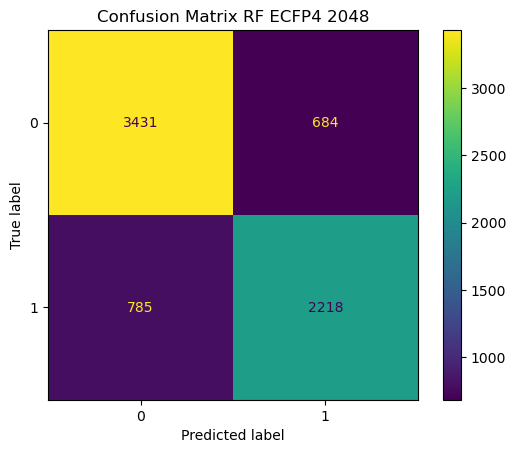

In [7]:
# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

# save fig
plt.title(f'Confusion Matrix RF ECFP4 2048')
#plt.savefig(f'./data/figs/confusion_matrix_rf_ecfp_2_1024.png', dpi=300)
#plt.clf()

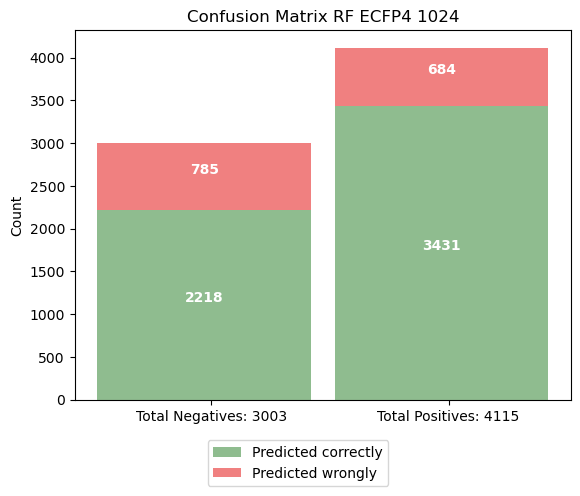

In [8]:
A = [cm[1, 1], cm[0, 0]]
B = [cm[1, 0], cm[0, 1]]

fig = plt.figure(facecolor="white")

ax = fig.subplots()
bar_width = 0.9
bar_l = np.arange(1, 3)
tick_pos = [i + (bar_width / 30) for i in bar_l]

ax2 = ax.bar(bar_l, A, width=bar_width, label="A", color="darkseagreen")
ax1 = ax.bar(bar_l, B, bottom=A, width=bar_width, label="B", color="lightcoral")
ax.set_ylabel("Count", fontsize=10)
totals = [sum([cm[1, 1], cm[1, 0]]), sum([cm[0, 0], cm[0, 1]])]
plt.legend(["Predicted correctly", "Predicted wrongly"], bbox_to_anchor=(0.45, -0.09), loc='upper center', ncol=1)
plt.xticks(tick_pos, [f"Total Negatives: {totals[0]}", f"Total Positives: {totals[1]}"], fontsize=10)
plt.title(f'Confusion Matrix RF ECFP4 1024')
plt.yticks(fontsize=10)

for r1, r2 in zip(ax2, ax1):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "%d" % h1, ha="center", va="bottom", color="white", fontsize=10, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., "%d" % h2, ha="center", va="bottom", color="white", fontsize=10, fontweight="bold")

#plt.savefig(f'./data/figs/barplotconfusion_matrix_{modelname}_{fp_used}.png', dpi=300, bbox_inches = 'tight')
#plt.clf()